In [1]:
import numpy as np
import pandas as pd
import shap
import time
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def type_selector(df):

    continuous_columns = df.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(df[feature].unique())< 30
    ]
    categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    return categorical_columns, continuous_columns

In [3]:
def feature_selector(X):
    continuous_columns = X.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(X[feature].unique())< 30
    ]
    categorical_columns = X.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    dummies_features = pd.get_dummies(X[categorical_columns])
    X = pd.concat([X, dummies_features], axis=1)
    dummies_features = dummies_features.columns.tolist()
    X = X.drop(categorical_columns, axis=1)

    return X

In [4]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgbm.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=100,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = catb.Pool(x_train, y_train)
        dvalid = catb.Pool(x_valid, y_valid)

        model = catb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=50, early_stopping_rounds=100
            #categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

    return estimators, encoders, oof_preds

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
bki = pd.read_csv('./data/bki.csv')

In [7]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [8]:
def bki_features_gen(df):
    df['AMT_ANNUITY_and_DAYS_CREDIT'] = df['AMT_ANNUITY']/df['DAYS_CREDIT']
    df['AMT_ANNUITY_and_DAYS_CREDIT_ENDDATE'] = df['AMT_ANNUITY']/df['DAYS_CREDIT_ENDDATE']
    df['AMT_ANNUITY_and_DAYS_ENDDATE_FACT'] = df['AMT_ANNUITY']/df['DAYS_ENDDATE_FACT']
    df['AMT_ANNUITY_and_AMT_CREDIT_MAX_OVERDUE'] = df['AMT_ANNUITY']/df['AMT_CREDIT_MAX_OVERDUE']
    df['AMT_ANNUITY_and_AMT_CREDIT_SUM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT_SUM']
    df['AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT'] = df['AMT_ANNUITY'] / df['AMT_CREDIT_SUM_DEBT']
    df['AMT_ANNUITY_and_AMT_CREDIT_SUM_LIMIT'] = df['AMT_ANNUITY'] / df['AMT_CREDIT_SUM_LIMIT']
    df['AMT_ANNUITY_and_AMT_CREDIT_SUM_OVERDUE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT_SUM_OVERDUE']
    df['AMT_ANNUITY_and_DAYS_CREDIT_UPDATE'] = df['AMT_ANNUITY'] / df['DAYS_CREDIT_UPDATE']
    
    df['DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT'] = df['DAYS_CREDIT_ENDDATE'] - df['DAYS_CREDIT']
    df['DAYS_CREDIT_ENDDATE_and_DAYS_ENDDATE_FACT'] = df['DAYS_CREDIT_ENDDATE'] - df['DAYS_ENDDATE_FACT']
    df['DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_UPDATE'] = df['DAYS_CREDIT_ENDDATE'] - df['DAYS_CREDIT_UPDATE']
    
    
    
    
    return df

In [9]:
bki_features_gen(bki)
bki = bki.replace([-np.inf, np.inf], [np.nan, np.nan])

In [10]:
def group_by_stat(df,features_list):
    
    for item in features_list:
        df[item+"_mean-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER'].transform('mean')
        df[item+"_median-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER'].transform('median')
        df[item+"_std-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER'].transform('std')
        df[item+"_count_"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER'].transform('count')
        df[item+"_min-"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER'].transform('min')
        df[item+"_max_"+ "APPLICATION_NUMBER"] = df.groupby(item)['APPLICATION_NUMBER'].transform('max')
    
    return df

In [11]:
categorical_columns,continuous_columns = type_selector(bki.drop('APPLICATION_NUMBER',1))

In [12]:
def freq_encoder(df,features_list):
    
    for item in features_list:
        freq_encoder = df[item].value_counts(normalize=True)
        df[item+"_freq_enc"] = df[item].map(freq_encoder)
    
    return df

In [13]:
train_freq_encoder = freq_encoder(bki, categorical_columns+continuous_columns)

In [14]:
bki_grouped_by_stat= group_by_stat(bki,categorical_columns+continuous_columns)

In [15]:
bki_grouped_by_stat

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_std-APPLICATION_NUMBER,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_count_APPLICATION_NUMBER,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_min-APPLICATION_NUMBER,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_max_APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_mean-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_median-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_std-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_count_APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_min-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_max_APPLICATION_NUMBER
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.810,0,...,NaN,NaN,NaN,NaN,1.235985e+08,123598219.0,103426.526027,2839,123423412,123779569
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.000,0,...,NaN,NaN,NaN,NaN,1.236021e+08,123607478.0,104585.744943,494,123423777,123779146
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,...,NaN,NaN,NaN,NaN,1.235979e+08,123599100.0,103449.235579,557,123423406,123778597
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,1.236021e+08,123601209.0,101980.006664,9271,123423429,123779529
4,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,1.235987e+08,123598736.0,103531.702770,626,123423854,123779325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945229,123673441,5235365,Closed,currency 1,2759.0,0,1298.0,1834.0,NaN,0,...,NaN,NaN,NaN,NaN,1.236103e+08,123620852.0,100795.854506,109,123431936,123773769
945230,123539211,5899696,Active,currency 1,359.0,0,1467.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,1.235997e+08,123596560.0,102692.748600,1783,123423501,123779529
945231,123686333,5445504,Closed,currency 1,1102.0,0,725.0,370.0,NaN,0,...,NaN,NaN,NaN,NaN,1.235987e+08,123595955.0,104484.438483,475,123424503,123779418
945232,123508200,6679628,Active,currency 1,1579.0,0,2085.0,NaN,2339.955,0,...,NaN,NaN,NaN,NaN,1.236029e+08,123603669.0,103767.662248,8613,123423441,123779577


In [16]:
reduce_mem_usage(bki_grouped_by_stat)

Memory usage of dataframe is 1622.60 MB
Memory usage after optimization is: 811.30 MB
Decreased by 50.0%


,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_std-APPLICATION_NUMBER,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_count_APPLICATION_NUMBER,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_min-APPLICATION_NUMBER,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_max_APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_mean-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_median-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_std-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_count_APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_min-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_max_APPLICATION_NUMBER
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.810547,0,...,NaN,NaN,NaN,NaN,123598544.0,123598216.0,103426.523438,2839,123423412,123779569
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.000000,0,...,NaN,NaN,NaN,NaN,123602144.0,123607480.0,104585.742188,494,123423777,123779146
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,...,NaN,NaN,NaN,NaN,123597944.0,123599104.0,103449.234375,557,123423406,123778597
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,123602120.0,123601208.0,101980.007812,9271,123423429,123779529
4,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,123598664.0,123598736.0,103531.703125,626,123423854,123779325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945229,123673441,5235365,Closed,currency 1,2760.0,0,1298.0,1834.0,NaN,0,...,NaN,NaN,NaN,NaN,123610288.0,123620848.0,100795.851562,109,123431936,123773769
945230,123539211,5899696,Active,currency 1,359.0,0,1467.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,123599664.0,123596560.0,102692.750000,1783,123423501,123779529
945231,123686333,5445504,Closed,currency 1,1102.0,0,725.0,370.0,NaN,0,...,NaN,NaN,NaN,NaN,123598664.0,123595952.0,104484.437500,475,123424503,123779418
945232,123508200,6679628,Active,currency 1,1579.0,0,2084.0,NaN,2339.955078,0,...,NaN,NaN,NaN,NaN,123602936.0,123603672.0,103767.664062,8613,123423441,123779577


In [17]:
train = pd.merge(train, bki_grouped_by_stat, how='left', on = 'APPLICATION_NUMBER')
test = pd.merge(test, bki_grouped_by_stat, how='left', on = 'APPLICATION_NUMBER')

In [18]:
test

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,...,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_std-APPLICATION_NUMBER,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_count_APPLICATION_NUMBER,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_min-APPLICATION_NUMBER,AMT_ANNUITY_and_AMT_CREDIT_SUM_DEBT_max_APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_mean-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_median-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_std-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_count_APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_min-APPLICATION_NUMBER,DAYS_CREDIT_UPDATE_max_APPLICATION_NUMBER
0,123724268,Cash,6181931.0,Closed,currency 1,744.0,0.0,14.0,14.0,NaN,...,NaN,NaN,NaN,NaN,123601240.0,123600760.0,102923.460938,9381.0,123423455.0,123779502.0
1,123456549,Cash,5470136.0,Closed,currency 1,2420.0,0.0,2206.0,2234.0,6538.455078,...,NaN,NaN,NaN,NaN,123593288.0,123582984.0,107107.234375,93.0,123424832.0,123775140.0
2,123456549,Cash,5459447.0,Closed,currency 1,2882.0,0.0,2732.0,2732.0,NaN,...,NaN,NaN,NaN,NaN,123585000.0,123555040.0,106837.109375,19.0,123425628.0,123741080.0
3,123428178,Credit Card,6692890.0,Closed,currency 1,532.0,0.0,30896.0,239.0,NaN,...,NaN,NaN,NaN,NaN,123603808.0,123608952.0,104411.015625,445.0,123424767.0,123778863.0
4,123428178,Credit Card,6617634.0,Closed,currency 1,1259.0,0.0,327.0,327.0,NaN,...,NaN,NaN,NaN,NaN,123601424.0,123599464.0,105510.835938,420.0,123426114.0,123779045.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476362,123433260,Cash,5657444.0,Active,currency 1,48.0,0.0,10912.0,NaN,0.000000,...,NaN,NaN,NaN,NaN,123601296.0,123601752.0,104405.671875,2102.0,123423358.0,123779585.0
476363,123433260,Cash,6657883.0,Active,currency 1,658.0,0.0,1096.0,NaN,0.000000,...,NaN,NaN,NaN,NaN,123594648.0,123599168.0,107040.625000,481.0,123423795.0,123779588.0
476364,123433260,Cash,6657532.0,Active,currency 1,776.0,0.0,1050.0,NaN,0.000000,...,NaN,NaN,NaN,NaN,123602936.0,123603672.0,103767.664062,8613.0,123423441.0,123779577.0
476365,123433260,Cash,6680154.0,Active,currency 1,658.0,0.0,324.0,NaN,0.000000,...,NaN,NaN,NaN,NaN,123601208.0,123597056.0,104410.539062,453.0,123424641.0,123779076.0


In [19]:
train_featured = feature_selector(train.drop('TARGET', 1))
test = feature_selector(test)
train_featured['TARGET'] = train['TARGET']

In [20]:
test

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,123724268,6181931.0,744.0,0.0,14.0,14.0,NaN,4.545000e+05,0.0,NaN,...,1,0,0,0,0,0,0,0,0,0
1,123456549,5470136.0,2420.0,0.0,2206.0,2234.0,6538.455078,3.247029e+04,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,123456549,5459447.0,2882.0,0.0,2732.0,2732.0,NaN,3.910500e+04,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
3,123428178,6692890.0,532.0,0.0,30896.0,239.0,NaN,0.000000e+00,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4,123428178,6617634.0,1259.0,0.0,327.0,327.0,NaN,1.125000e+06,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476362,123433260,5657444.0,48.0,0.0,10912.0,NaN,0.000000,1.237500e+05,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
476363,123433260,6657883.0,658.0,0.0,1096.0,NaN,0.000000,4.500000e+03,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
476364,123433260,6657532.0,776.0,0.0,1050.0,NaN,0.000000,6.750000e+05,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
476365,123433260,6680154.0,658.0,0.0,324.0,NaN,0.000000,6.125832e+04,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [21]:
import re
train_featured = train_featured.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_featured.drop(["TARGET"],1), 
                                                    train_featured['TARGET'], random_state=0)

In [23]:
categorical_columns,continuous_columns = type_selector(train_featured.drop('TARGET',1))

In [24]:
params_lgbm = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.05,          
                  "class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 48,
                  'reg_alpha': 2,
                  'reg_lambda': 50,
                  'subsample': 0.7252600946741159,
                  "max_depth": 5,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [25]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	training's auc: 0.651239	valid_1's auc: 0.544711


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.05, max_depth=5,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [26]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


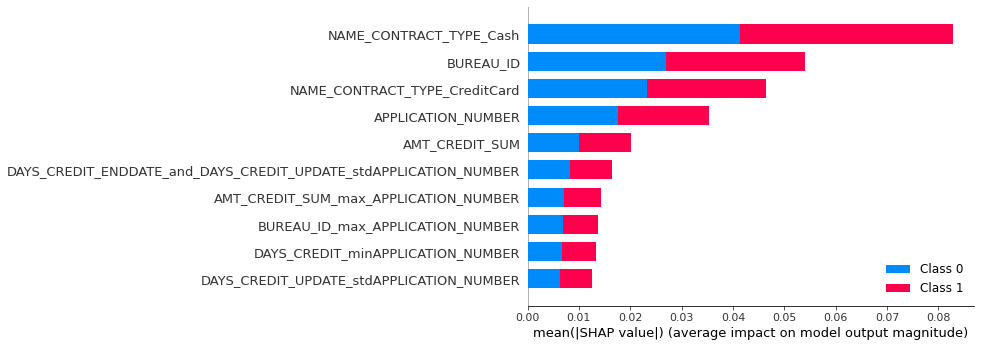

In [27]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=10, auto_size_plot=None)

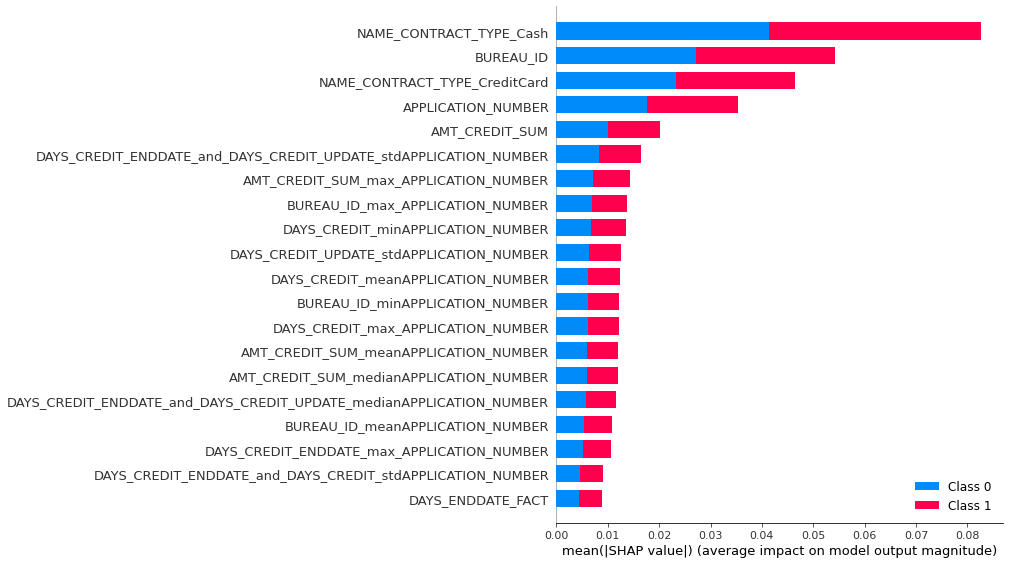

In [28]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [29]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']

173    9842.453518
1      6458.783523
174    5518.551849
0      4211.604221
7      2395.074542
          ...     
32        0.000000
150       0.000000
31        0.000000
154       0.000000
195       0.000000
Name: feature_importance_vals, Length: 196, dtype: float64

In [30]:
feature_importance['feature_importance_vals'].mean()

450.4932488056936

In [32]:
feature_importance.loc[feature_importance['feature_importance_vals'] > 450]

,col_name,feature_importance_vals
173,NAME_CONTRACT_TYPE_Cash,9842.453518
1,BUREAU_ID,6458.783523
174,NAME_CONTRACT_TYPE_CreditCard,5518.551849
0,APPLICATION_NUMBER,4211.604221
7,AMT_CREDIT_SUM,2395.074542
106,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_UPDATE_std...,1957.219202
67,AMT_CREDIT_SUM_max_APPLICATION_NUMBER,1704.980602
140,BUREAU_ID_max_APPLICATION_NUMBER,1631.535069
145,DAYS_CREDIT_minAPPLICATION_NUMBER,1602.253378
169,DAYS_CREDIT_UPDATE_stdAPPLICATION_NUMBER,1504.263926


In [33]:
feature_importance = feature_importance.loc[feature_importance['feature_importance_vals'] > 450]

In [34]:
feature_importance = feature_importance['col_name'].tolist()

In [35]:
test[feature_importance]

,NAME_CONTRACT_TYPE_Cash,BUREAU_ID,NAME_CONTRACT_TYPE_CreditCard,APPLICATION_NUMBER,AMT_CREDIT_SUM,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_UPDATE_stdAPPLICATION_NUMBER,AMT_CREDIT_SUM_max_APPLICATION_NUMBER,BUREAU_ID_max_APPLICATION_NUMBER,DAYS_CREDIT_minAPPLICATION_NUMBER,DAYS_CREDIT_UPDATE_stdAPPLICATION_NUMBER,...,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_freq_enc,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_UPDATE_max_APPLICATION_NUMBER,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_UPDATE,DAYS_CREDIT_UPDATE_freq_enc,AMT_ANNUITY_and_AMT_CREDIT_SUM,AMT_ANNUITY,AMT_ANNUITY_stdAPPLICATION_NUMBER,DAYS_CREDIT_UPDATE_minAPPLICATION_NUMBER,AMT_CREDIT_MAX_OVERDUE_stdAPPLICATION_NUMBER,AMT_ANNUITY_and_DAYS_CREDIT_UPDATE_meanAPPLICATION_NUMBER
0,1,6181931.0,0,123724268,4.545000e+05,103116.992188,123778512.0,123724268.0,123423655.0,102923.460938,...,0.011703,123779584.0,3.0,0.009926,NaN,NaN,NaN,123423455.0,NaN,NaN
1,1,5470136.0,0,123456549,3.247029e+04,103605.125000,123456552.0,123568705.0,123423782.0,107107.234375,...,0.005386,123779552.0,-28.0,0.000098,NaN,NaN,NaN,123424832.0,NaN,NaN
2,1,5459447.0,0,123456549,3.910500e+04,102705.445312,123769824.0,123778949.0,123423348.0,106837.109375,...,0.000647,123779584.0,0.0,0.000020,NaN,NaN,NaN,123425628.0,NaN,NaN
3,0,6692890.0,1,123428178,0.000000e+00,72289.054688,123779560.0,123428178.0,123423542.0,104411.015625,...,0.000006,123684992.0,30688.0,0.000471,NaN,0.000000,102767.523438,123424767.0,NaN,123601248.0
4,0,6617634.0,1,123428178,1.125000e+06,102594.203125,123779352.0,123428178.0,123424340.0,105510.835938,...,0.000089,123779336.0,16.0,0.000444,0.000000,0.000000,102767.523438,123426114.0,NaN,123601248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476362,1,5657444.0,0,123433260,1.237500e+05,158049.234375,123779440.0,123500048.0,123424329.0,104405.671875,...,0.000002,123738680.0,10864.0,0.002224,0.168335,20830.500000,129222.601562,123423358.0,102899.109375,123433264.0
476363,1,6657883.0,0,123433260,4.500000e+03,101872.640625,123779496.0,123601294.0,123426047.0,107040.625000,...,0.000171,123778840.0,439.0,0.000509,NaN,NaN,NaN,123423795.0,102899.109375,NaN
476364,1,6657532.0,0,123433260,6.750000e+05,106355.734375,123779584.0,123433260.0,123423801.0,103767.664062,...,0.000193,123775072.0,1034.0,0.009109,NaN,NaN,NaN,123423441.0,102899.109375,NaN
476365,1,6680154.0,0,123433260,6.125832e+04,106100.421875,123433264.0,123433260.0,123426047.0,104410.539062,...,0.008568,123778312.0,-324.0,0.000479,NaN,NaN,NaN,123424641.0,102899.109375,NaN


In [36]:
X_train, X_test, y_train, y_test = train_test_split(train_featured[feature_importance], 
                                                    train_featured['TARGET'], random_state=0)

In [37]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	training's auc: 0.65213	valid_1's auc: 0.540609


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.05, max_depth=5,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [38]:
train = train_featured[feature_importance].groupby('APPLICATION_NUMBER').mean()
test = test[feature_importance].groupby('APPLICATION_NUMBER').mean()

In [39]:
train

,NAME_CONTRACT_TYPE_Cash,BUREAU_ID,NAME_CONTRACT_TYPE_CreditCard,AMT_CREDIT_SUM,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_UPDATE_stdAPPLICATION_NUMBER,AMT_CREDIT_SUM_max_APPLICATION_NUMBER,BUREAU_ID_max_APPLICATION_NUMBER,DAYS_CREDIT_minAPPLICATION_NUMBER,DAYS_CREDIT_UPDATE_stdAPPLICATION_NUMBER,DAYS_CREDIT_meanAPPLICATION_NUMBER,...,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_freq_enc,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_UPDATE_max_APPLICATION_NUMBER,DAYS_CREDIT_ENDDATE_and_DAYS_CREDIT_UPDATE,DAYS_CREDIT_UPDATE_freq_enc,AMT_ANNUITY_and_AMT_CREDIT_SUM,AMT_ANNUITY,AMT_ANNUITY_stdAPPLICATION_NUMBER,DAYS_CREDIT_UPDATE_minAPPLICATION_NUMBER,AMT_CREDIT_MAX_OVERDUE_stdAPPLICATION_NUMBER,AMT_ANNUITY_and_DAYS_CREDIT_UPDATE_meanAPPLICATION_NUMBER
APPLICATION_NUMBER,,,,,,,,,,,,,,,,,,,,,
123423341,1,6.186110e+06,0,1.610447e+05,105775.531250,123707608.0,123491798.6,1.234233e+08,104303.171875,123603368.0,...,0.010776,123778720.0,3.750000,0.004626,0.000000,0.000000,102767.523438,1.234233e+08,100241.3750,123601248.0
123423345,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123423349,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123423351,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123423352,1,5.965158e+06,0,3.917700e+05,104881.828125,123770688.0,123593466.0,1.234234e+08,102079.218750,123599888.0,...,0.010947,123776176.0,33.500000,0.000202,0.000000,0.000000,102767.523438,1.234234e+08,103259.9375,123601248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123730828,1,6.091299e+06,0,2.601463e+05,103895.203125,123754872.0,123730828.0,1.234238e+08,101533.070312,123598032.0,...,0.001427,123775920.0,3895.375000,0.002219,0.002380,3657.979248,102767.523438,1.234238e+08,91360.9375,123619760.0
123730830,1,6.788704e+06,0,2.023192e+06,98699.710938,123769264.0,123730830.0,1.234248e+08,104623.609375,123603184.0,...,0.000233,123767392.0,1039.166626,0.002334,0.004879,77758.875000,30953.109375,1.234237e+08,NaN,123698432.0
123730833,1,5.709132e+06,0,6.750000e+05,100270.187500,123779584.0,123730833.0,1.234252e+08,102728.742188,123602328.0,...,0.000444,123779456.0,713.000000,0.000648,NaN,NaN,NaN,1.234238e+08,NaN,NaN


In [40]:
train.to_csv('train_bki.csv')

In [41]:
test.to_csv('test_bki.csv')